In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip '/content/drive/MyDrive/pr/lfw.zip'

Archive:  /content/drive/MyDrive/pr/lfw.zip
replace __MACOSX/._lfw? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._lfw          
replace __MACOSX/lfw/._German_Khan? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


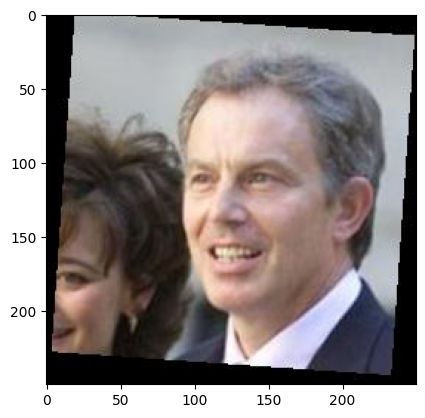

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:
# Extracting a sample image from the data
images, _ = next(iter(dataloader))
sample_image = images[27]

print("Dimensions of the sample image:", sample_image.shape)
print("\n")

num_channels = sample_image.size(0)
height = sample_image.size(1)
width = sample_image.size(2)

# Explaining what each dimension means
print(f"Number of Channels: {num_channels}")
print("This dimension represents the number of color channels in the image. In this case, there are 3 channels, which typically correspond to Red, Green, and Blue (RGB) channels in an image.\n")
print(f"Height of the image: {height}")
print("This dimension represents the height of the image, i.e., the number of pixels in the vertical direction.\n")
print(f"Width of the image: {width}")
print("This dimension represents the width of the image, i.e., the number of pixels in the horizontal direction.\n")

Dimensions of the sample image: torch.Size([3, 250, 250])


Number of Channels: 3
This dimension represents the number of color channels in the image. In this case, there are 3 channels, which typically correspond to Red, Green, and Blue (RGB) channels in an image.

Height of the image: 250
This dimension represents the height of the image, i.e., the number of pixels in the vertical direction.

Width of the image: 250
This dimension represents the width of the image, i.e., the number of pixels in the horizontal direction.



# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(256)

        # Decoder Layers
        self.dec_upsample0 = nn.Upsample(size=(32, 32), mode='bilinear', align_corners=False)
        self.dec_conv0 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec_bn0 = nn.BatchNorm2d(128)
        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode='bilinear', align_corners=False)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_upsample2 = nn.Upsample(size=(125, 125), mode='bilinear', align_corners=False)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='bilinear', align_corners=False)
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        return x

    def decoder(self, x):
        x = self.dec_upsample0(x)
        x = F.relu(self.dec_bn0(self.dec_conv0(x)))
        x = self.dec_upsample1(x)
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = self.dec_upsample3(x)
        x = self.dec_bn3(self.dec_conv3(x))
        x = torch.sigmoid(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
model = AE()

sample_input = torch.randn(1, 3, 250, 250)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
sample_input = sample_input.to(device)

with torch.no_grad():
    encoded_output = model.encoder(sample_input)
    decoded_output = model.decoder(encoded_output)

print("Shape of the encoded output:", encoded_output.shape)
print("Shape of the decoded output:", decoded_output.shape)

Shape of the encoded output: torch.Size([1, 256, 15, 15])
Shape of the decoded output: torch.Size([1, 3, 250, 250])


# Check the dimensions to make sure your forward path is working properly
* From the shapes outputted, we can conclude that the encoding and decoding process is working properly.
* The number of channels and spatial dimensions match between the encoded output, decoded output, and the sample image.



##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

# Task: Choosing an appropriate loss function for your task
* Mean Squared Error (MSE): since For reconstruction tasks, MSE loss is commonly used
* The primary goal of an autoencoder is to reconstruct its input as accurately as possible.
* MSE measures the average squared difference between the original input and the reconstructed output.
* Minimizing MSE encourages the model to produce reconstructions that closely match the input data.


Ref: https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss
Ref: https://www.quora.com/Which-one-is-the-better-loss-function-to-train-autoencoder-mean-square-error-or-binary-cross-entropy

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters in the model:", total_params)

Total number of parameters in the model: 1349449


In [12]:
criterion = nn.MSELoss()

In [13]:
# Creating an optimizer for training
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

# If your loss is not decreasing what do you have to do to troubleshoot it ?
From the output of the below block of code, it is evident that the loss is **decreasing gradually**, but had it been the case where my loss is not decreasing, in that case I would have taken following steps to trouble shoot it:

1. Check Model Architecture: Ensure the model's architecture is suitable, addressing issues like vanishing gradients.
> Initially my encoder had 2 layers and decoder had 3 layers and the minimum loss that I reached was 0.08, so decrease it further I added one more layer in both encoder and decoder also changed changed mode in decoder from the initial 'nearest' to 'bilinear'
>> Earlier I was using SGD optimizer step and that had a loss of around 0.02 as the best loss, so tried Adam optimizer to further decrease the loss value. 


2. Loss Function: Select an appropriate loss function, such as MSE for autoencoders focused on reconstruction.

3. Learning Rate: Adjust the learning rate for optimal convergence, experimenting with different rates and scheduling.

4. Architecture Complexity: Gradually increase model complexity, avoiding overfitting by monitoring and adjusting.
> Add one layer in both encoder and decoder while making sure that the output of one layer is compatible in terms of dimensions as the input of the subsequent layer

5. Input Scaling: Normalize input data to ensure consistent scales and improve model learning.

6. Data Quality: Examine and preprocess training data for quality and integrity to enhance model performance.

7. Use Transposed Convolution in Decoder:
Transposed convolution combines upsampling and convolution, potentially improving reconstruction quality.
> Replaced nn.Upsample and nn.ConvTranspose2d with only nn.ConvTranspose2d for upsampling in the decoder.

Ref: https://www.techtarget.com/searchenterpriseai/feature/How-to-troubleshoot-8-common-autoencoder-limitations and ChatGPT


In [14]:
no_of_epochs = 10

# Training Loop
for epoch in range(no_of_epochs):
    epoch_loss = 0.0

    for data in dataloader:
        inputs, _ = data

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.0204
Epoch 2, Loss: 0.0090
Epoch 3, Loss: 0.0062
Epoch 4, Loss: 0.0052
Epoch 5, Loss: 0.0046
Epoch 6, Loss: 0.0042
Epoch 7, Loss: 0.0038
Epoch 8, Loss: 0.0035
Epoch 9, Loss: 0.0034
Epoch 10, Loss: 0.0031


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

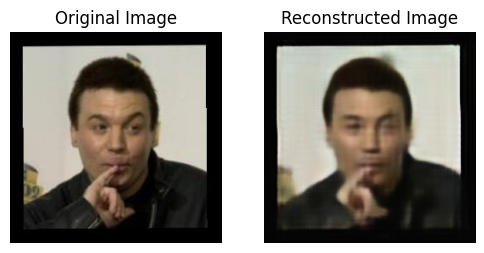

In [21]:

model.eval()

def tensor_to_image(tensor):
    return tensor.permute(1, 2, 0).cpu().numpy()

images, _ = next(iter(dataloader))
original_img = images[0].unsqueeze(0)

if torch.cuda.is_available():
    original_img = original_img.cuda()

with torch.no_grad():
    reconstructed_img = model(original_img)

# Convert tensors to images for display
original_img_display = tensor_to_image(original_img[0])
reconstructed_img_display = tensor_to_image(reconstructed_img[0])

# Plot the original and reconstructed images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(original_img_display)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img_display)
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

# How is adding noise affecting the decoded image?
Adding noise to the image lead to degradation of the image quality. This has manifested in several ways:

* Loss of Detail: Noise has obscured finer details in the image, making it harder
to discern textures and edges.
* Reduced Contrast: The sharpness between different color tones and brightness levels has been reduced, leading to a flatter looking image.

Adding noise to an image might seem counterintuitive when considering image quality, but there are several positive applications and effects of introducing noise in image processing and related fields

* Sharper Illusion: Controlled noise enhances tonal differences, creating the illusion of increased sharpness.
* Fine Detail Preservation: Embracing digital noise helps maintain fine details lost in standard noise reduction.

and many more

Ref: https://medium.com/photo-dojo/dont-fear-the-grain-263a37a64b87

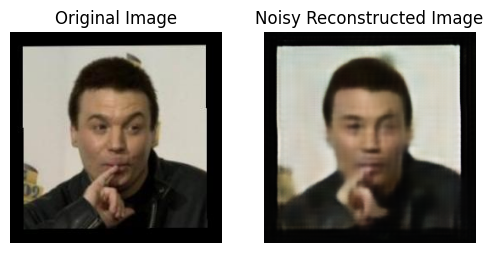

In [22]:
def plot_noisy_reconstruction(original, noisy_reconstruction):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original.permute(1, 2, 0))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Noisy Reconstructed Image')
    plt.imshow(noisy_reconstruction.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

model.eval()
with torch.no_grad():
    encoded = model.encoder(original_img)

    # Add normally distributed noise
    noise = torch.randn(encoded.shape) * 0.1
    if torch.cuda.is_available():
        noise = noise.cuda()

    noisy_encoded = encoded + noise
    noisy_reconstructed_img = model.decoder(noisy_encoded)

    # Plot
    plot_noisy_reconstruction(original_img.cpu().squeeze(), noisy_reconstructed_img.cpu().squeeze())
